# TPCC OU Data Collection

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import lightgbm as lgb
from datetime import datetime
from pathlib import Path
from scipy import stats

In [6]:
sqlsmith = True
BENCHMARK_NAME = f"tpcc-{'sqlsmith' if sqlsmith else 'default'}"
results_dir = Path.home() / "postgres/cmudb/tscout/results/" / BENCHMARK_NAME
results_dir

PosixPath('/home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith')

In [13]:
experiments = sorted(list(results_dir.glob("*")))
print(f"Experiments: {experiments}")
latest_experiment = experiments[-1]
result_filepaths = list(latest_experiment.glob("**/*.csv"))
print(f"Latest experiment: {exp_dir}")

Experiments: [PosixPath('/home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-14-15'), PosixPath('/home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21')]
Latest experiment: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-17_21-01-18


#### Load Data

In [14]:
ou_name_to_df = dict()
run_id = 0

for filepath in result_filepaths:
    ou_name = filepath.stem
    
    if run_id != int(filepath.parent.stem): 
        continue
    
    if os.stat(filepath).st_size > 0:
        print(f"Loading filepath: {filepath}")
        ou_name_to_df[ou_name] = pd.read_csv(filepath)

Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecSeqScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecHashJoinImpl.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecResult.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecModifyTable.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecIndexScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecAgg.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecIndexOnlyScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021-11-18_00-25-21/0/ExecSubqueryScan.csv
Loading filepath: /home/glhess/postgres/cmudb/tscout/results/tpcc-sqlsmith/2021

In [15]:
for (ou_name, ou_df) in ou_name_to_df.items():
    print(f"OU Name: {ou_name}, ou_df shape: {ou_df.shape}")

OU Name: ExecSeqScan, ou_df shape: (12102, 36)
OU Name: ExecHashJoinImpl, ou_df shape: (82, 44)
OU Name: ExecResult, ou_df shape: (9289, 36)
OU Name: ExecModifyTable, ou_df shape: (59364, 51)
OU Name: ExecIndexScan, ou_df shape: (339549, 43)
OU Name: ExecAgg, ou_df shape: (301, 64)
OU Name: ExecIndexOnlyScan, ou_df shape: (37, 43)
OU Name: ExecSubqueryScan, ou_df shape: (1232, 35)
OU Name: ExecSubPlan, ou_df shape: (655196, 35)
OU Name: ExecWindowAgg, ou_df shape: (2938, 85)
OU Name: ExecIncrementalSort, ou_df shape: (29, 55)
OU Name: ExecLimit, ou_df shape: (1150740, 42)
OU Name: ExecSampleScan, ou_df shape: (1284, 42)
OU Name: ExecMaterial, ou_df shape: (94, 36)
OU Name: ExecSort, ou_df shape: (2311, 42)
OU Name: ExecLockRows, ou_df shape: (48847, 36)
OU Name: ExecNestLoop, ou_df shape: (824, 40)


In [16]:
ou_name_to_df.keys()

dict_keys(['ExecSeqScan', 'ExecHashJoinImpl', 'ExecResult', 'ExecModifyTable', 'ExecIndexScan', 'ExecAgg', 'ExecIndexOnlyScan', 'ExecSubqueryScan', 'ExecSubPlan', 'ExecWindowAgg', 'ExecIncrementalSort', 'ExecLimit', 'ExecSampleScan', 'ExecMaterial', 'ExecSort', 'ExecLockRows', 'ExecNestLoop'])

# Pre-processing

#### Get IndexScan OU Data

In [17]:
target_ou = 'ExecNestLoop'
df = ou_name_to_df[target_ou]

### Remove Start/End Time (since elapsed_us == end_time - start_time)

In [18]:
cols_to_remove = ['start_time', 'end_time', 'cpu_id', 'query_id']
df = df.drop(cols_to_remove, axis=1)

#### Remove constant columns

In [19]:
cols_to_remove = []
for col in df.columns:
    if df[col].nunique() == 1: 
            cols_to_remove.append(col)

df = df.drop(cols_to_remove, axis=1)
print(f"Dropped zero-variance columns: {cols_to_remove}")
print(f"Num Remaining: {len(df.columns)}, Num Removed {len(cols_to_remove)}")

Dropped zero-variance columns: ['NestLoopState_js_ps_type', 'NestLoopState_js_ps_async_capable', 'NestLoopState_js_ps_scanopsfixed', 'NestLoopState_js_ps_outeropsfixed', 'NestLoopState_js_ps_inneropsfixed', 'NestLoopState_js_ps_resultopsfixed', 'NestLoopState_js_ps_scanopsset', 'NestLoopState_js_ps_outeropsset', 'NestLoopState_js_ps_inneropsset', 'NestLoopState_js_ps_resultopsset', 'NestLoop_join_plan_type', 'NestLoop_join_plan_parallel_aware', 'NestLoop_join_plan_async_capable', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'memory_bytes']
Num Remaining: 19, Num Removed 17


### Summarize Features

In [20]:
all_target_cols = ['cpu_cycles', 'instructions', 'cache_references', 'cache_misses', 'ref_cpu_cycles', 'network_bytes_read', 'network_bytes_written', 'disk_bytes_read', 'disk_bytes_written', 'memory_bytes', 'elapsed_us']
feat_cols = [col for col in df.columns if col not in all_target_cols]
features = df[feat_cols]
features.describe()

,NestLoopState_js_jointype,NestLoopState_js_single_match,NestLoopState_nl_NeedNewOuter,NestLoopState_nl_MatchedOuter,NestLoop_join_plan_startup_cost,NestLoop_join_plan_total_cost,NestLoop_join_plan_plan_rows,NestLoop_join_plan_plan_width,NestLoop_join_plan_parallel_safe,NestLoop_join_plan_plan_node_id,NestLoop_join_jointype,NestLoop_join_inner_unique
count,824.000000,824.000000,824.000000,824.000000,8.240000e+02,8.240000e+02,8.240000e+02,824.000000,824.000000,824.000000,824.000000,824.000000
mean,0.643204,0.055825,0.962379,0.066748,2.549677e+05,3.855960e+09,2.562080e+11,55.515777,0.208738,1.930825,0.643204,0.002427
std,0.959130,0.229723,0.190394,0.249736,7.308229e+06,1.093610e+11,7.287677e+12,76.267068,0.406653,2.255022,0.959130,0.049237
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000e-02,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000e+00,4.051875e+00,1.000000e+00,8.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000e+00,4.653638e+02,2.200000e+01,29.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,8.405449e-02,3.461233e+03,6.814250e+03,75.000000,0.000000,3.000000,1.000000,0.000000
max,5.000000,1.000000,1.000000,1.000000,2.097860e+08,3.139138e+12,2.091900e+14,650.000000,1.000000,24.000000,5.000000,1.000000


### Summarize Targets

In [21]:
target_cols = [col for col in df.columns if col in all_target_cols]
targets = df[target_cols]
targets.describe()

,cpu_cycles,instructions,cache_references,cache_misses,ref_cpu_cycles,disk_bytes_written,elapsed_us
count,8.240000e+02,8.240000e+02,8.240000e+02,8.240000e+02,8.240000e+02,824.000000,824.000000
mean,1.821340e+08,1.796292e+08,2.379095e+06,1.689133e+05,9.977471e+07,26.087379,40537.708738
std,6.617395e+08,6.593383e+08,8.159357e+06,6.420946e+05,3.583168e+08,393.945814,138498.202986
min,3.949000e+03,4.190000e+03,1.760000e+02,1.700000e+01,1.830000e+03,0.000000,7.000000
25%,3.124475e+04,4.045225e+04,1.358250e+03,7.300000e+01,1.259725e+04,0.000000,18.000000
50%,2.538395e+05,1.431615e+05,9.253000e+03,2.039000e+03,5.441350e+04,0.000000,40.000000
75%,4.569862e+06,5.432118e+06,1.244000e+05,1.468050e+04,1.244456e+06,0.000000,1637.500000
max,4.749324e+09,5.393621e+09,6.953281e+07,1.332352e+07,2.423093e+09,9280.000000,930288.000000


## Show Features

In [22]:
features.head(5)

,NestLoopState_js_jointype,NestLoopState_js_single_match,NestLoopState_nl_NeedNewOuter,NestLoopState_nl_MatchedOuter,NestLoop_join_plan_startup_cost,NestLoop_join_plan_total_cost,NestLoop_join_plan_plan_rows,NestLoop_join_plan_plan_width,NestLoop_join_plan_parallel_safe,NestLoop_join_plan_plan_node_id,NestLoop_join_jointype,NestLoop_join_inner_unique
0,1,0,1,0,0.000000,1.110000,1.0,32,0,5,1,0
1,0,0,1,0,0.000000,0.032500,1.0,378,0,1,0,0
2,1,0,1,0,0.000000,3328.600000,37800.0,15,0,2,1,0
3,0,0,1,0,1.294607,1.364607,1.0,53,0,5,0,0
4,0,0,1,0,0.000000,36.690000,417.0,106,0,1,0,0


## Show targets

In [23]:
targets.head(5)

,cpu_cycles,instructions,cache_references,cache_misses,ref_cpu_cycles,disk_bytes_written,elapsed_us
0,119102,70035,2958,1315,19234,0,14
1,75977,49377,185,115,18079,0,16
2,297883460,214670351,897700,93208,222041239,0,93793
3,3949,4190,176,2488,146689,0,33
4,124752,53202,2465,17,1830,0,19


In [24]:
def plot_histograms(df): 
    for col_name in df.columns: 
        res = stats.relfreq(df[col_name], numbins=10)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                         res.frequency.size)
        fig = plt.figure(figsize=(6, 2))
        ax = fig.add_subplot(1, 1, 1)
        ax.bar(x, res.frequency, width=res.binsize)
        ax.set_title(col_name)
        ax.set_xlim([x.min(), x.max()])

#### Visualizations

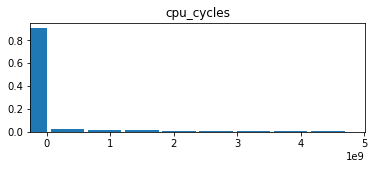

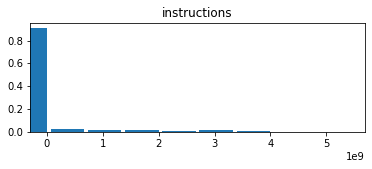

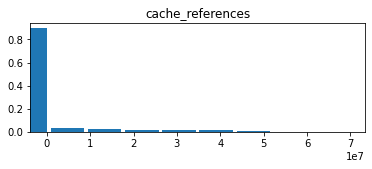

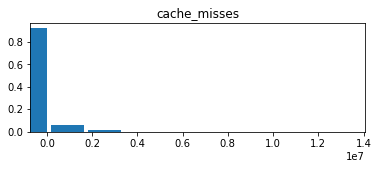

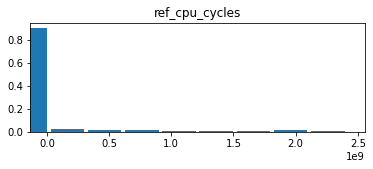

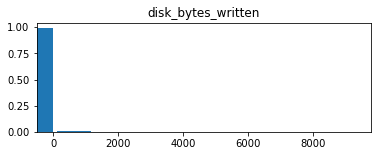

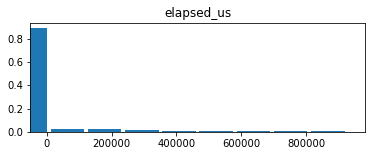

In [25]:
plot_histograms(targets)

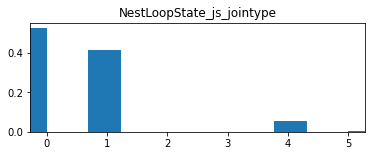

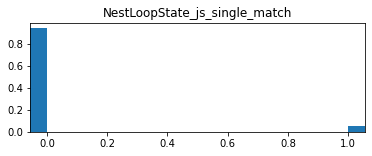

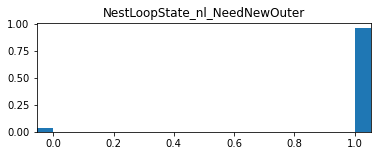

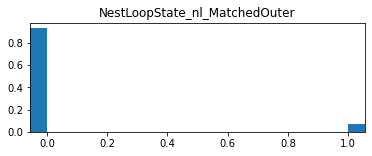

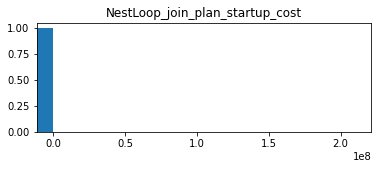

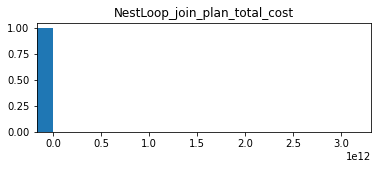

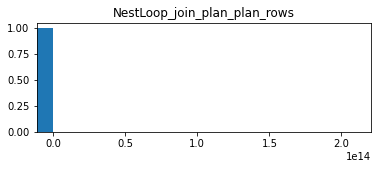

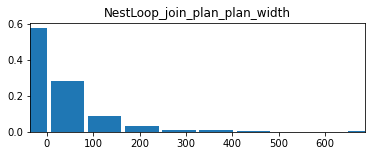

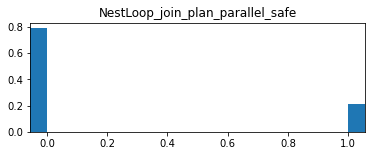

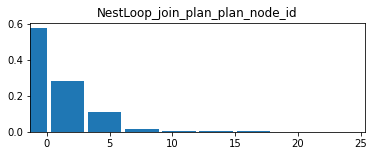

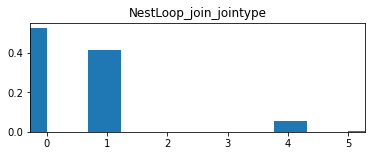

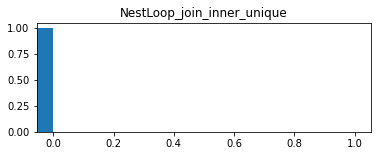

In [26]:
plot_histograms(features)

#### Correlation Heatmap

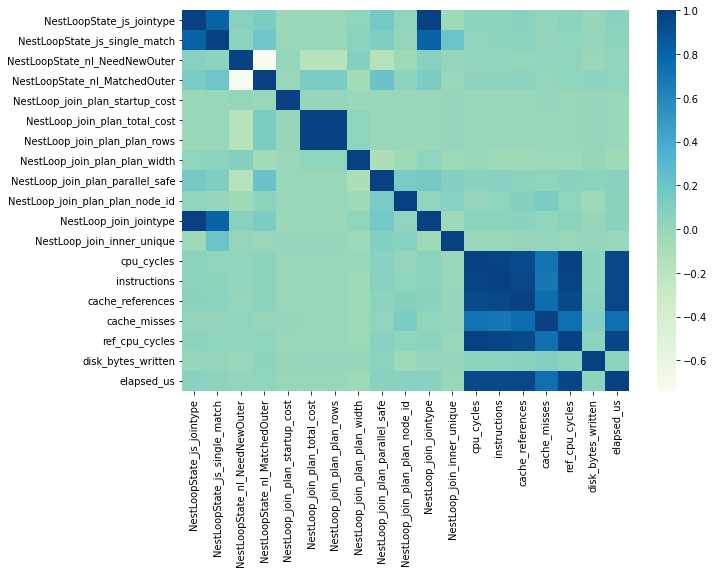

In [27]:
df_corr = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(df_corr, cmap='GnBu')
plt.show()

# Feature Analysis - PCA

In [28]:
def pca_summary(df):
    pca = PCA(n_components=None)
    pca.fit(df)
    print(f"Input Dimensionality: {len(df.columns)}")
    for component_idx, explained_var_pct in enumerate(pca.explained_variance_ratio_):
        print(f"Component {component_idx} explains {round(explained_var_pct*100, 2)}% of variance")

In [29]:
pca_summary(df)

Input Dimensionality: 19
Component 0 explains 100.0% of variance
Component 1 explains 0.0% of variance
Component 2 explains 0.0% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance
Component 10 explains 0.0% of variance
Component 11 explains 0.0% of variance
Component 12 explains 0.0% of variance
Component 13 explains 0.0% of variance
Component 14 explains 0.0% of variance
Component 15 explains 0.0% of variance
Component 16 explains 0.0% of variance
Component 17 explains 0.0% of variance
Component 18 explains 0.0% of variance


In [30]:
features.columns

Index(['NestLoopState_js_jointype', 'NestLoopState_js_single_match',
       'NestLoopState_nl_NeedNewOuter', 'NestLoopState_nl_MatchedOuter',
       'NestLoop_join_plan_startup_cost', 'NestLoop_join_plan_total_cost',
       'NestLoop_join_plan_plan_rows', 'NestLoop_join_plan_plan_width',
       'NestLoop_join_plan_parallel_safe', 'NestLoop_join_plan_plan_node_id',
       'NestLoop_join_jointype', 'NestLoop_join_inner_unique'],
      dtype='object')

In [31]:
pca_summary(features)

Input Dimensionality: 12
Component 0 explains 100.0% of variance
Component 1 explains 0.0% of variance
Component 2 explains 0.0% of variance
Component 3 explains 0.0% of variance
Component 4 explains 0.0% of variance
Component 5 explains 0.0% of variance
Component 6 explains 0.0% of variance
Component 7 explains 0.0% of variance
Component 8 explains 0.0% of variance
Component 9 explains 0.0% of variance
Component 10 explains 0.0% of variance
Component 11 explains 0.0% of variance
